In [132]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import dask
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
from scipy.interpolate import griddata # Other package for regridding
# Import some extra functions from utils folder
import sys
import calendar as cal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
#seasons = ['Annual','DJF','MAM','JJA','SON']
root_data_path = '/data/mmenegoz/daily/' # local, first test for only one year
save_data = '/data/mmenegoz/use_case_cci_snow'

In [134]:
%%time
# First test over the Alps for one year
first_year=2001
last_year=2002
period = slice(str(first_year)+'-01-01',str(last_year)+'-12-31')
# Alpine domain
latlim_ext,lonlim_ext=slice(43,48), slice(5,17)
# the data is extracted only the first time
from pathlib import Path
path = Path(save_data+'/Alpine_snow.nc')
if path.is_file():
    print(f'The file {path} already exists')
    ds_alps = xr.open_mfdataset(save_data+'/Alpine_snow.nc', parallel=True)#, chunks={'time': -1, 'lat': 80, 'lon': 240})
else:
    print(f'The file {path} does not exist')
    print(f'Extracting the data')
    # Parallelization?
    ds = xr.open_mfdataset(root_data_path+'*/*.nc', parallel=True)#, chunks={'time': -1, 'lat': 3600, 'lon': 7200})
    ds_alps=ds.sel(lat=latlim_ext, lon=lonlim_ext,time=period)
    ds_alps.to_netcdf(save_data+'/Alpine_snow_2001.nc')

The file /data/mmenegoz/use_case_cci_snow/Alpine_snow.nc does not exist
Extracting the data
CPU times: user 1min 51s, sys: 2.39 s, total: 1min 53s
Wall time: 2min 10s


In [135]:
ds_alps

<xarray.Dataset>
Dimensions:          (lat: 100, lon: 240, time: 730)
Coordinates:
  * lat              (lat) float64 43.02 43.08 43.12 43.17 ... 47.88 47.92 47.98
  * lon              (lon) float64 5.025 5.075 5.125 5.175 ... 16.88 16.93 16.98
  * time             (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2002-12-31
Data variables:
    scfg_interp      (time, lat, lon) float64 dask.array<chunksize=(31, 100, 240), meta=np.ndarray>
    coverage         (time, lat, lon) int64 dask.array<chunksize=(31, 100, 240), meta=np.ndarray>
    coverage_interp  (time, lat, lon) int64 dask.array<chunksize=(31, 100, 240), meta=np.ndarray>
    mask_ice         (time, lat, lon) float32 dask.array<chunksize=(31, 100, 240), meta=np.ndarray>
    mask_water       (time, lat, lon) float32 dask.array<chunksize=(31, 100, 240), meta=np.ndarray>
Attributes:
    processed:                  A linear interpolation on the time dimension ...
    title:                      ESA CCI snow on ground product level L3C dail...
    institution:                Remote Sensing Research Group, Institute of G...
    source:                     AVHRR_NOAA-7_GAC mosaic from ESA Cloud CCI pr...
    date_created:               20211109T162200Z
    history:                    20211109T162200Z: ESA snow_cci SCF processing...
    references:                 http://snow-cci.enveo.at/
    tracking_id:                afb79860-80e9-43f0-9a4c-d798cc7845d5
    Conventions:                CF-1.9
    product_version:            2.0
    format_version:             CCI Data Standards v2.3
    summary:                    The SCFG product provides daily information o...
    keywords:                   snow, cover, AVHRR
    id:                         19820101-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv...
    naming_authority:           ch.unibe
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    cdm_data_type:              Grid
    comment:                    The following auxiliary data sets are used fo...
    creator_name:               Remote Sensing Research Group
    creator_url:                http://giub.unibe.ch
    creator_email:              snow_CCI_AVHRR@giub.unibe.ch
    project:                    Climate Change Initiative - European Space Ag...
    geospatial_lat_min:         -90
    geospatial_lat_max:         90
    geospatial_lon_min:         -180
    geospatial_lon_max:         180
    geospatial_vertical_min:    0
    geospatial_vertical_max:    0
    geospatial_lon_resolution:  0.05
    geospatial_lat_resolution:  0.05
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    time_coverage_start:        19820101T000000Z
    time_coverage_end:          19820101T235959Z
    time_coverage_duration:     P1D
    time_coverage_resolution:   P1D
    standard_name_vocabulary:   CF Standard Name Table v78
    license:                    ESA CCI Data Policy: free and open access
    platform:                   NOAA-7
    sensor:                     AVHRR
    spatial_resolution:         0.05 degree
    key_variables:              scfg
    doi:                        10.5285/3f034f4a08854eb59d58e1fa92d207b6

In [136]:
time_extract='2001-03-01'
ds_alps_check=ds_alps.sel(time=time_extract)

Topography

In [137]:
ds_topo = xr.open_dataset('/data/mmenegoz/GMTED2010/GMTED2010_15n015_00625deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds_topo.elevation
elevation_std = ds_topo.elevation_stddev

Plot

In [138]:
cmap='Blues'
cmap_cov='Reds'
levels=plot.arange(0,100,10)
levels_coverage=plot.arange(0,31,1)

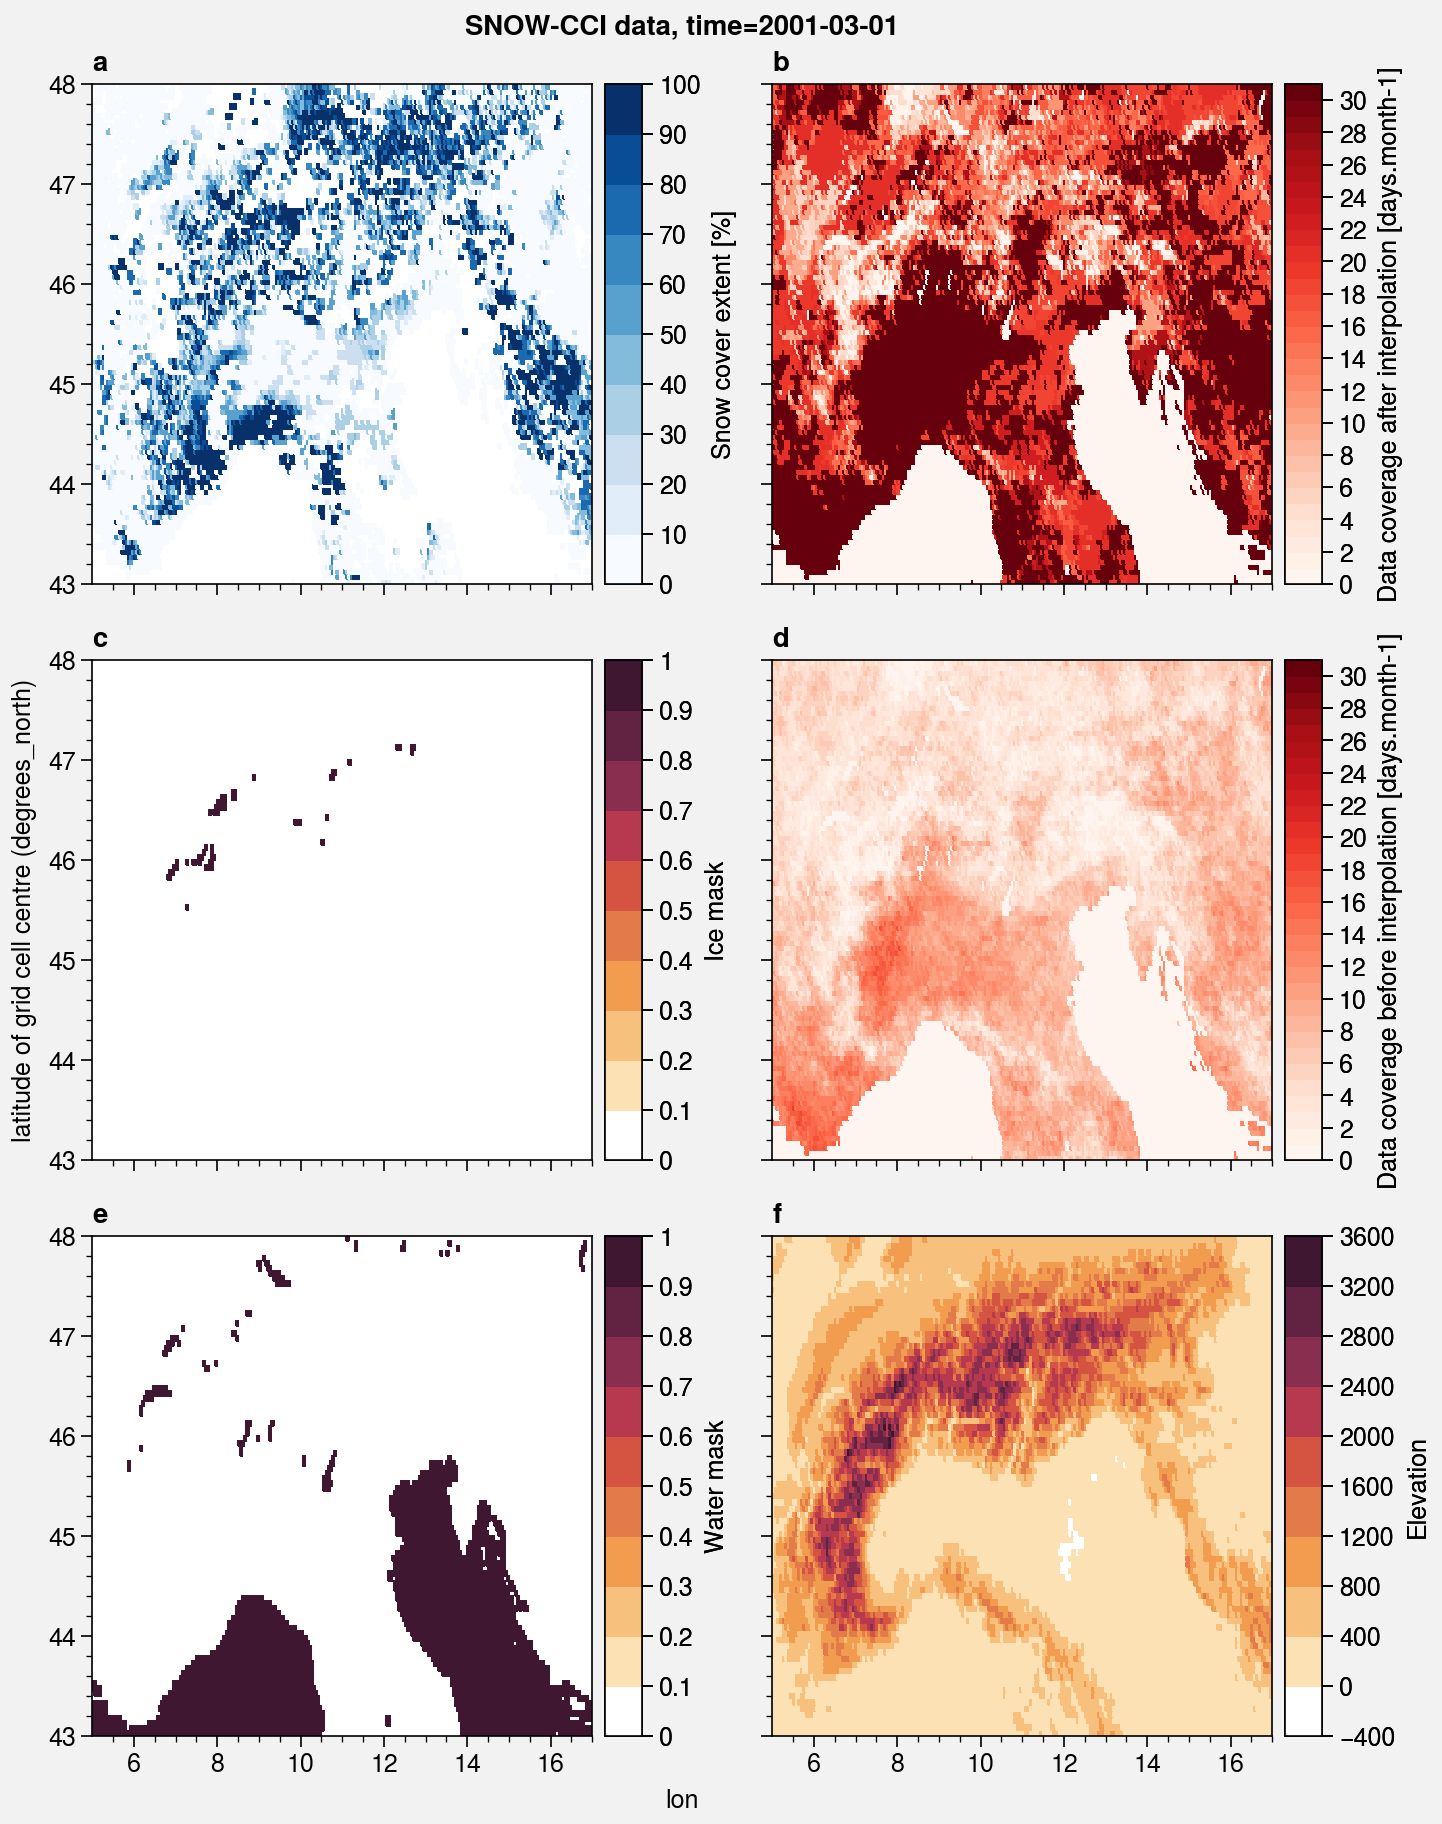

In [139]:
fig,axs = plot.subplots(nrows=3, ncols=2)
axs[0,0].pcolormesh(ds_alps_check.scfg_interp, levels=levels, colorbar='r', cmap=cmap, colorbar_kw={'label': 'Snow cover extent [%]'})
axs[0,1].pcolormesh(ds_alps_check.coverage_interp, levels=levels_coverage, colorbar='r',cmap=cmap_cov, colorbar_kw={'label': 'Data coverage after interpolation [days.month-1]'})
axs[1,0].pcolormesh(ds_alps_check.mask_ice, colorbar='r',colorbar_kw={'label': 'Ice mask'})
axs[1,1].pcolormesh(ds_alps_check.coverage, levels=levels_coverage, colorbar='r',cmap=cmap_cov, colorbar_kw={'label': 'Data coverage before interpolation [days.month-1]'})
axs[2,0].pcolormesh(ds_alps_check.mask_water, colorbar='r',colorbar_kw={'label': 'Water mask'})
axs[2,1].pcolormesh(elevation, colorbar='r',colorbar_kw={'label': 'Elevation'})
axs.format(
    suptitle='SNOW-CCI data, time='+time_extract,
    abc=True
)

In [140]:
dsi_topo = ds_topo.interp(lat=ds_alps.lat, lon=ds_alps.lon)

In [141]:
dsi_topo_check=dsi_topo.interp(lat=ds_topo.lat,lon=ds_topo.lon)

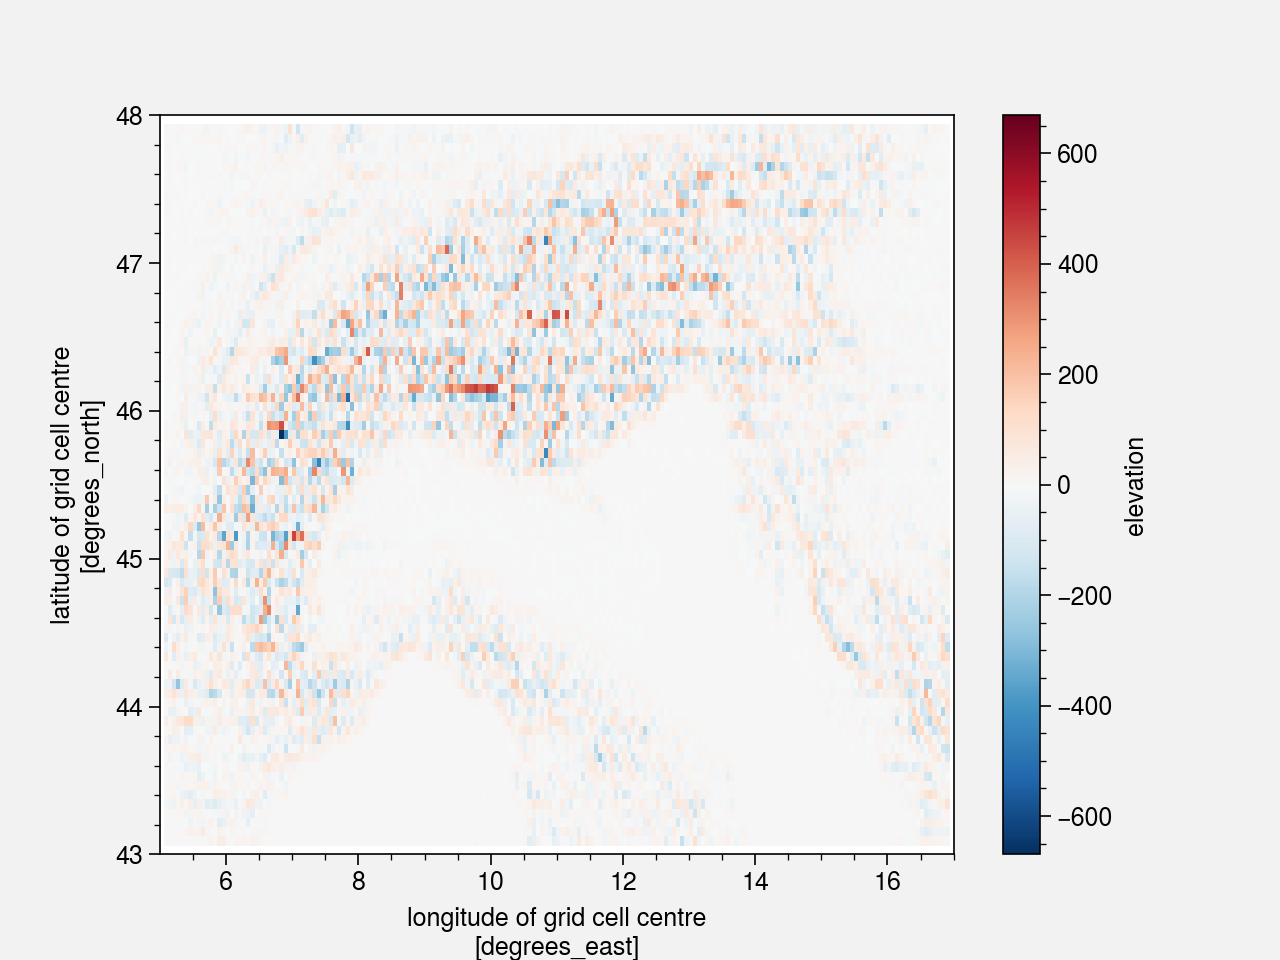

In [142]:
# Errors related to the interpolation applied two times
check=dsi_topo_check.elevation-ds_topo.elevation
check.plot()

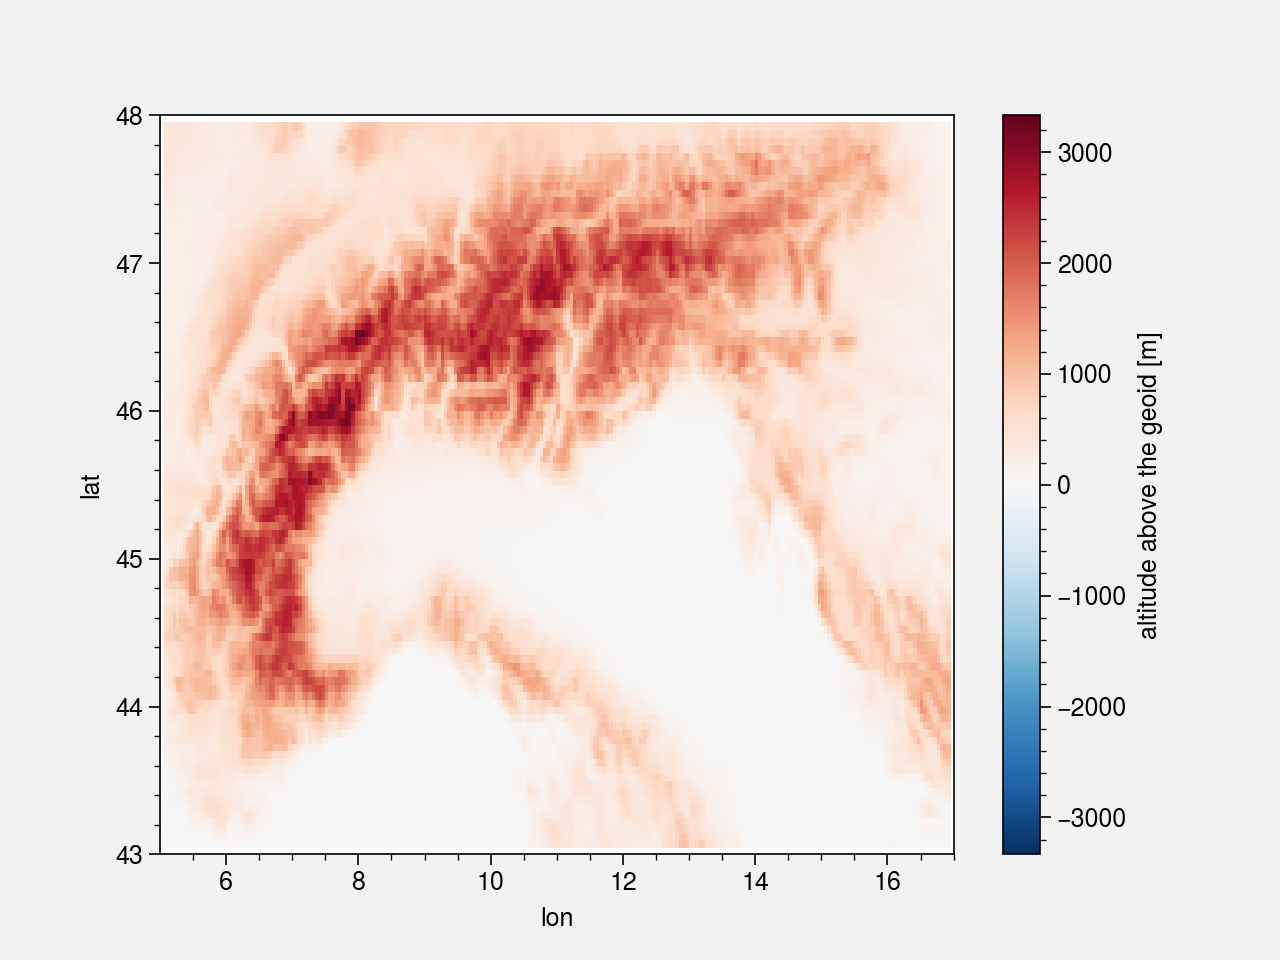

In [143]:
dsi_topo.elevation.plot()

In [144]:
# Testing 3D plots (Could be interesting for analysis on elevation bands)

In [145]:
delta=0.05
latlim_short,lonlim_short=slice(44+delta,48-delta), slice(5+delta,17-delta)

In [146]:
x,y = np.meshgrid(dsi_topo.lon.sel(lon=lonlim_short),dsi_topo.lat.sel(lat=latlim_short))

In [147]:
dsi_topo_short=dsi_topo.elevation.sel(lon=lonlim_short,lat=latlim_short)
x.shape, y.shape, dsi_topo_short.shape

((78, 238), (78, 238), (78, 238))

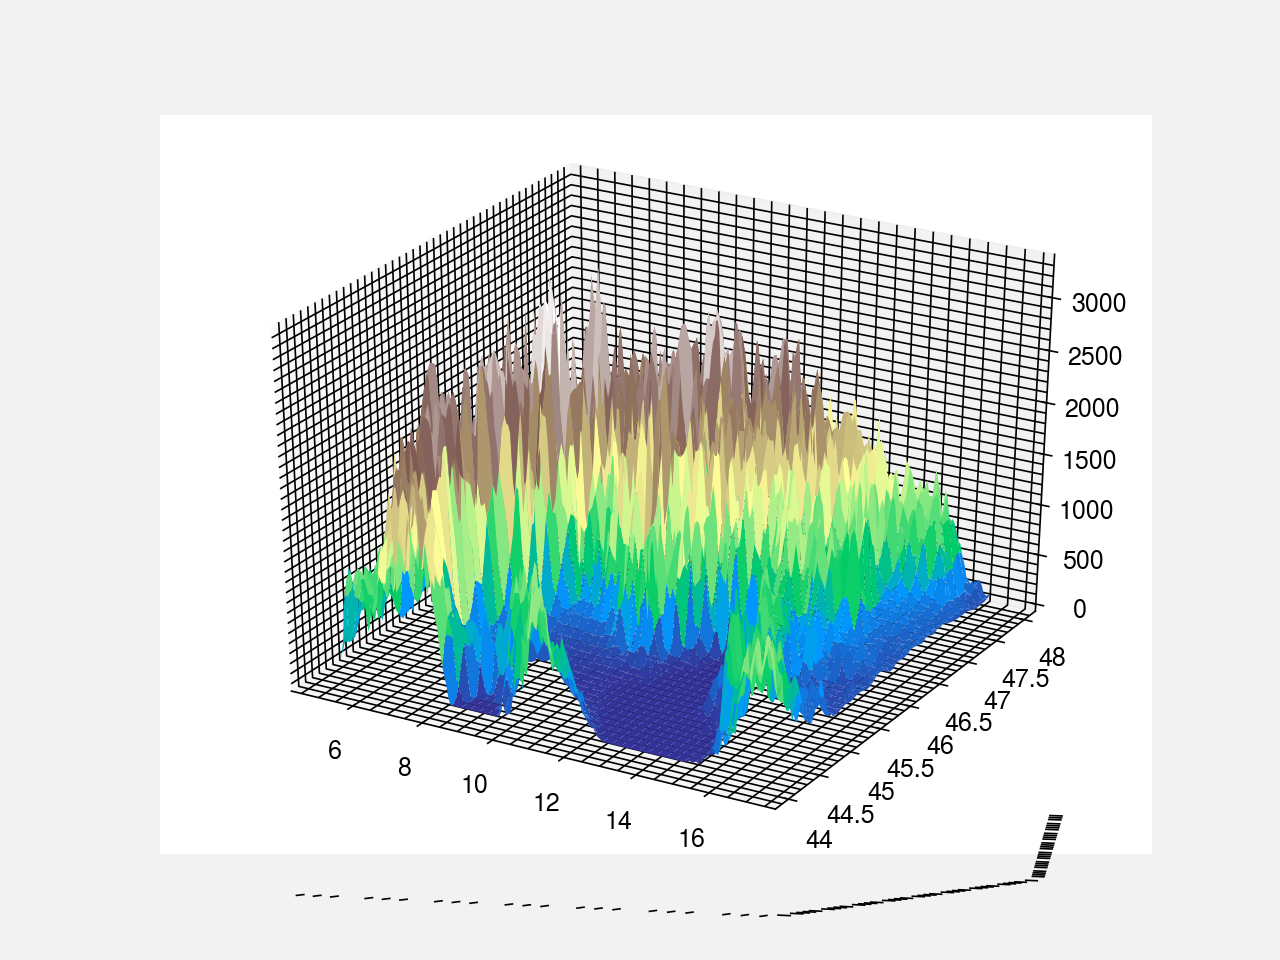

In [148]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(x,y,dsi_topo_short,cmap='terrain')

In [149]:
# Moving plot (Could be interesting for visualisation)
# https://jackmckew.dev/3d-terrain-in-python.html
#terrain_cmap = plt.cm.get_cmap('terrain')
#def matplotlib_to_plotly(cmap, pl_entries):
#    h = 1.0/(pl_entries-1)
#    pl_colorscale = []
#
#    for k in range(pl_entries):
#        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
#        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
#
#    return pl_colorscale
#
#terrain = matplotlib_to_plotly(terrain_cmap, 255)

In [150]:
#import plotly
#import plotly.graph_objects as go
#plotly.offline.init_notebook_mode(connected=True)
#
#fig = go.Figure(data=[go.Surface(colorscale=terrain,z=dsi_topo_short)])
#
#fig.update_layout(title='Random 3D Terrain')
#
# Note that include_plotlyjs is used as cdn so that the static site generator can read it and present it on the browser. This is not typically required.
#html = plotly.offline.plot(fig, filename='3d-terrain-plotly.html',include_plotlyjs='cdn')

In [151]:
#from IPython.core.display import HTML
#HTML(html)

***Snow cover duration***

In [152]:
# Parameters to compute snow cover duration
scf_threshold=0.05
min_available_values=15
min_available_values2=20 # Second value for testing/comparison

In [153]:
# Defining the time for the monthly data
time_nbdays = pd.date_range(start=str(first_year)+'-01-01',end=str(last_year+1)+'-01-01',freq='M')
reference_time = pd.Timestamp(str(first_year)+'-01-01')

In [154]:
# Initialise 12 month per year nbdays array
ds_nbdays = xr.Dataset({
    'nbdays': xr.DataArray(
        data=np.full((ds_alps.lat.shape[0],ds_alps.lon.shape[0],time_nbdays.shape[0]), np.nan),
        dims=["lat", "lon", "time"],
        coords=dict(
            lon=(["lon"], ds_alps.lon),
            lat=(["lat"], ds_alps.lat),
            time=time_nbdays,
            reference_time=reference_time,
        ),
        name='nbdays',
        attrs=dict(
            description="snow cover duration, minimum available value="+str(min_available_values),
            units="days.month-1",
        ),
        ),
    'nbdays2': xr.DataArray(
        data=np.full((ds_alps.lat.shape[0],ds_alps.lon.shape[0],time_nbdays.shape[0]), np.nan),
        dims=["lat", "lon", "time"],
        coords=dict(
            lon=(["lon"], ds_alps.lon),
            lat=(["lat"], ds_alps.lat),
            time=time_nbdays,
            reference_time=reference_time,
        ),
        name='nbdays',
        attrs=dict(
            description="snow cover duration, minimum available value="+str(min_available_values2),
            units="days.month-1",
        ),
        ),
    'nbdays_filled': xr.DataArray(
        data=np.full((ds_alps.lat.shape[0],ds_alps.lon.shape[0],time_nbdays.shape[0]), np.nan),
        dims=["lat", "lon", "time"],
        coords=dict(
            lon=(["lon"], ds_alps.lon),
            lat=(["lat"], ds_alps.lat),
            time=time_nbdays,
            reference_time=reference_time,
        ),
        name='nbdays_filled',
        attrs=dict(
            description="snow cover duration, monthly filled",
            units="days.month-1",
        ),
        )
    },
    attrs = {'documentation': 'Computing snow cover duration from CCI_SNOW snow cover fraction.\r'+
             'Snow cover fraction threshold:'+str(scf_threshold*100)+'%.\r'+
             'The data is monthly extrapolated in nbdays_filled when more than '+str(min_available_values)+' days of data is available'}
)    

In [182]:
# Defining the time for the yearly data
time_yearly_nbdays = pd.date_range(start=str(first_year)+'-01-01',end=str(last_year+1)+'-01-01',freq='Y')

In [183]:
time_yearly_nbdays.shape[0]

2

In [185]:
# Initialise year nbdays array
ds_yearly_nbdays = xr.Dataset({
    'nbdays': xr.DataArray(
        data=np.full((ds_alps.lat.shape[0],ds_alps.lon.shape[0],time_yearly_nbdays.shape[0]), np.nan),
        dims=["lat", "lon", "time"],
        coords=dict(
            lon=(["lon"], ds_alps.lon),
            lat=(["lat"], ds_alps.lat),
            time=time_yealry_nbdays,
            reference_time=reference_time,
        ),
        name='nbdays',
        attrs=dict(
            description="snow cover duration, minimum available value="+str(min_available_values),
            units="days.month-1",
        ),
        ),
    'nbdays2': xr.DataArray(
        data=np.full((ds_alps.lat.shape[0],ds_alps.lon.shape[0],time_yearly_nbdays.shape[0]), np.nan),
        dims=["lat", "lon", "time"],
        coords=dict(
            lon=(["lon"], ds_alps.lon),
            lat=(["lat"], ds_alps.lat),
            time=time_yealry_nbdays,
            reference_time=reference_time,
        ),
        name='nbdays',
        attrs=dict(
            description="snow cover duration, minimum available value="+str(min_available_values2),
            units="days.month-1",
        ),
        ),
    'nbdays_filled': xr.DataArray(
        data=np.full((ds_alps.lat.shape[0],ds_alps.lon.shape[0],time_yearly_nbdays.shape[0]), np.nan),
        dims=["lat", "lon", "time"],
        coords=dict(
            lon=(["lon"], ds_alps.lon),
            lat=(["lat"], ds_alps.lat),
            time=time_yealry_nbdays,
            reference_time=reference_time,
        ),
        name='nbdays_filled',
        attrs=dict(
            description="snow cover duration, monthly filled",
            units="days.month-1",
        ),
        )
    },
    attrs = {'documentation': 'Computing snow cover duration from CCI_SNOW snow cover fraction.\r'+
             'Snow cover fraction threshold:'+str(scf_threshold*100)+'%.\r'+
             'The data is monthly extrapolated in nbdays_filled when more than '+str(min_available_values)+' days of data is available'}
)    

In [156]:
ds_nbdays.sel(time=str(year)+'-'+str(imonth)).nbdays_filled.shape

(100, 240, 1)

In [186]:
# nbdays calculation (To complete with yearly data if possible)
for iyear, year in enumerate(range(first_year, last_year+1, 1)):
    for imonth in range(1,13,1):
        numday_month=cal.monthrange(year, imonth)[1]
        print('year='+str(year)+', month='+str(imonth)+', number of days='+str(numday_month))
        ds_tmp=ds_alps.sel(time=str(year)+'-'+str(imonth))
        binary_tmp=xr.where(ds_tmp.scfg_interp > scf_threshold, 1., 0.)
        binary=xr.where(xr.ufuncs.isnan(ds_tmp.scfg_interp), np.nan, binary_tmp)
        xnbdays=binary.sum(dim='time',skipna=True,min_count=min_available_values)
        xnbdays2=binary.sum(dim='time',skipna=True,min_count=min_available_values2)
        cov=ds_alps.coverage_interp.sel(time=str(year)+'-'+str(imonth)+'-01')
        xnbdays_filled=(xnbdays/cov)*numday_month
        ds_nbdays.sel(time=str(year)+'-'+str(imonth)).nbdays_filled[:,:,0]=xnbdays_filled
        ds_nbdays.sel(time=str(year)+'-'+str(imonth)).nbdays[:,:,0]=xnbdays
        ds_nbdays.sel(time=str(year)+'-'+str(imonth)).nbdays2[:,:,0]=xnbdays2

year=2001, month=1, number of days=31
year=2001, month=2, number of days=28
year=2001, month=3, number of days=31
year=2001, month=4, number of days=30
year=2001, month=5, number of days=31
year=2001, month=6, number of days=30
year=2001, month=7, number of days=31
year=2001, month=8, number of days=31
year=2001, month=9, number of days=30
year=2001, month=10, number of days=31
year=2001, month=11, number of days=30
year=2001, month=12, number of days=31
year=2002, month=1, number of days=31
year=2002, month=2, number of days=28
year=2002, month=3, number of days=31
year=2002, month=4, number of days=30
year=2002, month=5, number of days=31
year=2002, month=6, number of days=30
year=2002, month=7, number of days=31
year=2002, month=8, number of days=31
year=2002, month=9, number of days=30
year=2002, month=10, number of days=31
year=2002, month=11, number of days=30
year=2002, month=12, number of days=31


In [187]:
ds_nbdays

<xarray.Dataset>
Dimensions:         (lat: 100, lon: 240, time: 24)
Coordinates:
  * lon             (lon) float64 5.025 5.075 5.125 5.175 ... 16.88 16.93 16.98
  * lat             (lat) float64 43.02 43.08 43.12 43.17 ... 47.88 47.92 47.98
  * time            (time) datetime64[ns] 2001-01-31 2001-02-28 ... 2002-12-31
    reference_time  datetime64[ns] 2001-01-01
Data variables:
    nbdays          (lat, lon, time) float64 nan nan nan nan ... 0.0 3.0 20.0
    nbdays2         (lat, lon, time) float64 nan nan nan nan ... nan 3.0 20.0
    nbdays_filled   (lat, lon, time) float64 nan nan nan nan ... 0.0 4.286 20.0
Attributes:
    documentation:  Computing snow cover duration from CCI_SNOW snow cover fr...

In [188]:
# Check plot for one specific date
time_check='2002-04'
#ds_alps_check=ds_alps.sel(time=time_extract)
levels_nbdays=plot.arange(0,31,1)
levels_elev=plot.arange(0,1000,1000)
cmap='winter_r'

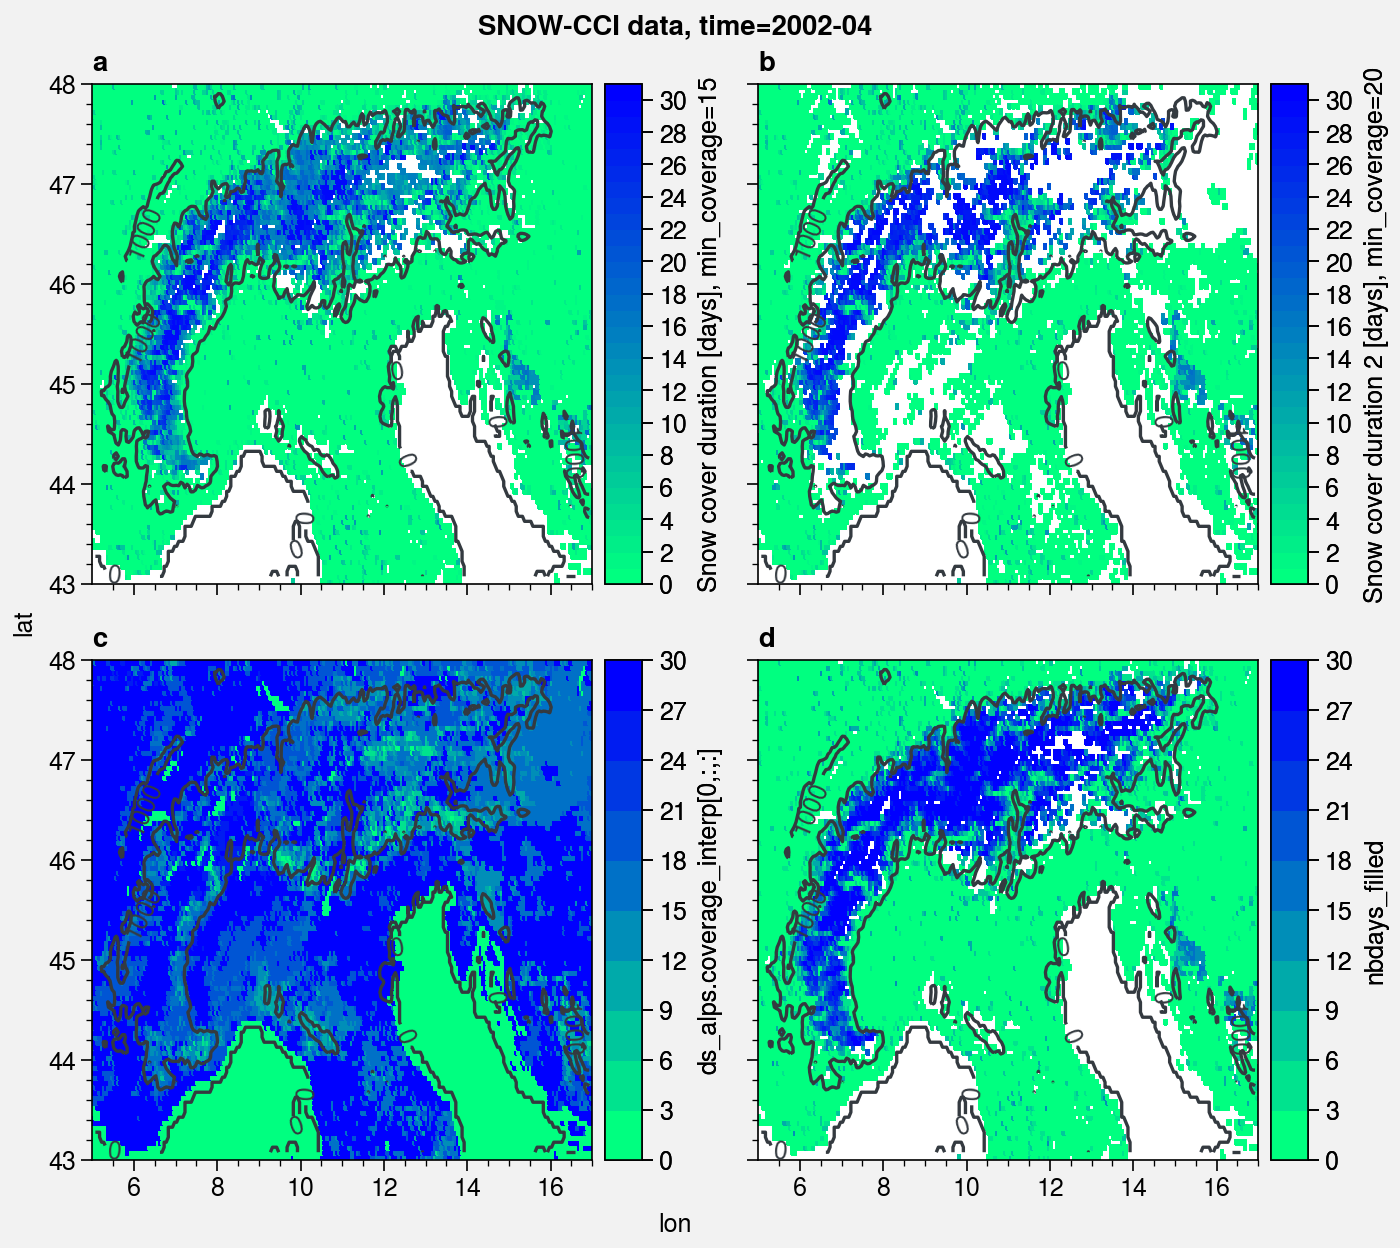

In [189]:
fig,axs = plot.subplots(nrows=2, ncols=2)
axs[0,0].pcolormesh(ds_nbdays.nbdays.sel(time=time_check)[:,:,0], levels=levels_nbdays, cmap=cmap, colorbar='r', colorbar_kw={'label': 'Snow cover duration [days], min_coverage='+str(min_available_values)})
axs[0,0].contour(dsi_topo.elevation, levels=levels_elev, color='gray8',labels=True,lw=1.2)
axs[0,1].pcolormesh(ds_nbdays.nbdays2.sel(time=time_check)[:,:,0], levels=levels_nbdays, cmap=cmap, colorbar='r', colorbar_kw={'label': 'Snow cover duration 2 [days], min_coverage='+str(min_available_values2)})
axs[0,1].contour(dsi_topo.elevation, levels=levels_elev, color='gray8',labels=True,lw=1.2)
axs[1,0].pcolormesh(ds_alps.coverage_interp.sel(time=time_check)[0,:,:], cmap=cmap, colorbar='r', colorbar_kw={'label': 'ds_alps.coverage_interp[0,:,:]'})
axs[1,0].contour(dsi_topo.elevation, levels=levels_elev, color='gray8',labels=True,lw=1.2)
axs[1,1].pcolormesh(ds_nbdays.nbdays_filled.sel(time=time_check)[:,:,0], cmap=cmap, colorbar='r', colorbar_kw={'label': 'nbdays_filled'})
axs[1,1].contour(dsi_topo.elevation, levels=levels_elev, color='gray8',labels=True,lw=1.2)

axs.format(
    suptitle='SNOW-CCI data, time='+time_check,
    abc=True
)

***Yearly nbdays calculation***

In [191]:
# Yearly nbdays calculation
#for iyear, year in enumerate(range(first_year, last_year+1, 1)):
    